# Modelo Not BIO 32-bilstm-dropout0.3-dense-rmsprop-sigmoid

In [1]:
MODELO = "bilstm32_dropout0.3_dense_rmsprop"
LABELS = ["NADA",
          "B-CENTRO", "I-CENTRO", "B-CONTACTO", "B-DIRECCION", "I-DIRECCION", "B-HISTORIA", 
          "B-IDENT", "I-IDENT", "B-PERSONA", "I-PERSONA", "B-REFERENCIA", "B-UBICACION", "I-UBICACION"]

model = "bio-noda-bilstmcrf-128"

## Imports

In [2]:
import os
import json
import logging
import argparse
import pandas as pd
import numpy as np
import seaborn as sbn

from pathlib import Path
from sklearn import metrics
from IPython.display import display
from matplotlib import pyplot as plt

from galennlp_keras_utils.sequences import (
    GeneratorConf,
    multilabel,
)

In [3]:
# Avoid printing warnings.
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow
from tensorflow.keras import models as k_models
from tensorflow.keras import layers as k_layers
from tensorflow.keras import metrics as k_metrics
from tensorflow.keras import optimizers as k_optimizers
from keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint as latest_checkpoint
from tensorflow.keras.callbacks import CSVLogger

import galennlp_keras_crf as _crf

print(tensorflow.__version__)

if tensorflow.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else:
    print("The installed version of TensorFlow does not include GPU support.")

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

2.10.0-dev20220404
The installed version of TensorFlow includes GPU support.
Num GPUs Available:  1


C:\ProgramData\Anaconda3\envs\Galen\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220404). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Random seeds

In [4]:
import random

seed = 12345

tensorflow.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Workspace Directions

In [5]:
# Workspace.
workspace_dir = os.path.abspath('') + '\\'
print(workspace_dir)

# Results.
results_dir = workspace_dir + 'results_guille-bio\\' + model + '\\'
Path(results_dir).mkdir(exist_ok=True)
print(results_dir)

# Data.
data_dir = 'C:\\Galen\\galen_guille\\bio-bin\\'
Path(data_dir).mkdir(exist_ok=True)
print(data_dir)

# Model.
model_dir = workspace_dir + 'models_galen\\' + model + '\\'
Path(model_dir).mkdir(exist_ok=True)
print(model_dir)

D:\Galen\deidentificacion\
D:\Galen\deidentificacion\results_guille-bio\bio-noda-bilstmcrf-128\
C:\Galen\galen_guille\bio-bin\
D:\Galen\deidentificacion\models_galen\bio-noda-bilstmcrf-128\


## Etiquetas

In [6]:
with open(data_dir +'etiquetas-bio.txt', 'r') as file:
    print (file.read())

O
B-CENTRO
I-CENTRO
B-CONTACTO
B-DIRECCION
I-DIRECCION
B-HISTORIA
B-IDENT
I-IDENT
B-PERSONA
I-PERSONA
B-REFERENCIA
B-UBICACION
I-UBICACION



## Construir Modelo

In [7]:
def build_model(n_features, n_classes, mask_value):
    "build keras model"
    inputs = k_layers.Input(shape=(None, n_features))
    masked = k_layers.Masking(mask_value=mask_value)(inputs)
    rnl = k_layers.Bidirectional(k_layers.LSTM(128, recurrent_dropout=0.3, return_sequences=True))(masked)
    dense = k_layers.TimeDistributed(k_layers.Dense(n_classes))(rnl)
    
    crf = _crf.CRF(n_classes)
    print(crf.transitions)
    output = crf(dense)
    model = k_models.Model(inputs, output)
    
    model.compile(
        optimizer=k_optimizers.Adam(learning_rate=0.0005),
        loss=crf.loss,
        metrics=[crf.accuracy]
    )
    display(model.summary())
    return model

## Configuración Entrenamiento

In [8]:
args_train = [
    Path(data_dir + 'train.npy'),
]
args_valid = [
    Path(data_dir + 'val.npy')
]
args_test = [
    Path(data_dir + 'test.npy')
]

args_conf = Path(model_dir + 'conf_galen.json')
with open(args_conf) as fd_conf:
    settings = json.load(fd_conf)

eval_settings = settings.get("eval", {})
    
mask_value = settings['generator']['mask_value']
batch_size = settings['generator']['batch_size']
epochs = settings['generator']['epochs']

ref_metric = eval_settings.get("metric", "f1_samples")
patience = eval_settings.get("early_stop", None)
threshold = eval_settings.get("threshold", 0.5)

print("CONFIG:")
print("epochs:", str(epochs))
print("batch_size:", str(batch_size))
print("mask_value:", str(mask_value))
print("onehot:", str(settings['generator']['onehot']))
print("is_weighted:", str(settings['generator']['is_weighted']))
print("metric:", str(ref_metric))
print("early_stop:", str(patience))
print("threshold:", str(threshold))

classes = settings['data']['classes']
null_class = None #settings['data']['null_class']

print()
print("DATA:")
print("classes:", len(classes))
print("null class:", null_class)
print("tags:")
for idx, tag in enumerate(classes):
    print("%d: %s" % (idx, tag))

CONFIG:
epochs: 75
batch_size: 32
mask_value: -99
onehot: True
is_weighted: True
metric: f1_macro
early_stop: 25
threshold: 0.5

DATA:
classes: 14
null class: None
tags:
0: O
1: B-CENTRO
2: I-CENTRO
3: B-CONTACTO
4: B-DIRECCION
5: I-DIRECCION
6: B-HISTORIA
7: B-IDENT
8: I-IDENT
9: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Función de Evaluación

In [9]:
def evaluar_red(network, testgen, null_class, threshold=0.5):
    """evaluar la red con el generador de test proporcionado

    network - keras model
    testgen - dataset iterator
    null_class - índice de la clase nula (o None)
    """
    prediccion = testgen.predict(network)
    # print(prediccion.shape)
    p_prob = prediccion[:, 0, :]
    p_pred = (p_prob > threshold) + 0.0
    p_true = prediccion[:, 1, :]
    valid_labels = list(range(p_true.shape[-1]))
    if null_class is not None:
        valid_labels = [x for x in valid_labels if x != null_class]
    m_micro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="micro",
        zero_division=0
    )
    m_macro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="macro",
        zero_division=0
    )
    m_samples = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="samples",
        zero_division=0
    )
    out = {
        #"roc_auc_macro": metrics.roc_auc_score(p_true, p_prob, average="macro"),
        #"roc_auc_micro": metrics.roc_auc_score(p_true, p_prob, average="micro"),
        "pr_auc_macro": metrics.average_precision_score(p_true, p_prob, average="macro"),
        "pr_auc_micro": metrics.average_precision_score(p_true, p_prob, average="micro"),
        "f1_micro": m_micro[2],
        "f1_macro": m_macro[2],
        "f1_samples": m_samples[2],
        "precision_micro": m_micro[0],
        "precision_macro": m_macro[0],
        "precision_samples": m_samples[0],
        "recall_micro": m_micro[1],
        "recall_macro": m_macro[1],
        "recall_samples": m_samples[1],
    }
    return out, prediccion

## Crear generadores de datos

In [10]:
gen_conf = GeneratorConf(**settings["generator"])
display(gen_conf)

gen_train = multilabel.MultiLabelTrainSequence(args_train, gen_conf)
gen_valid = multilabel.MultiLabelTrainSequence(args_valid, gen_conf)
gen_test = multilabel.MultiLabelTrainSequence(args_test, gen_conf)

features = gen_train.manifest().input_segment.size()
classes = gen_train.manifest().output_segment.size()

print()
print("Pesos de clases")
display(gen_train.pseudo_class_weights)

print()
print("FEATURES:", features)
print("CLASSES:", classes)
print("TAGS:")
for idx, tag in sorted(gen_train.manifest().tags.items()):
    print("%02d: %s" % (idx, tag))

GeneratorConf(batch_size=32, epochs=75, onehot=True, exclusive_onehot=False, is_weighted=True, mask_value=-99, classes=None, null_class=None, flatten=False)


Pesos de clases


{0: 0.07184551314938423,
 1: 98.70268620268621,
 2: 27.188262002858824,
 3: 1074.252491694352,
 4: 23096.428571428572,
 5: 4199.350649350649,
 6: 2566.2698412698414,
 7: 733.219954648526,
 8: 1443.5267857142858,
 9: 105.70447858777378,
 10: 206.21811224489795,
 11: 334.7308488612836,
 12: 135.4629241726016,
 13: 166.76121712222795}


FEATURES: 416
CLASSES: 14
TAGS:
00: O
01: B-CENTRO
02: I-CENTRO
03: B-CONTACTO
04: B-DIRECCION
05: I-DIRECCION
06: B-HISTORIA
07: B-IDENT
08: I-IDENT
09: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Crear Modelo

In [11]:
red = build_model(features, classes, mask_value=mask_value)

checkpoint_path = model_dir + 'model_checkpoint.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor="val_viterbi_accuracy",
                              mode="max",
                              verbose=2)

None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 416)]       0         
                                                                 
 masking (Masking)           (None, None, 416)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        558080    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 14)         3598      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, None, 14)          196       
                                                                 
Total params: 561,874
Trainable params: 561,874
Non-trai

None

## Entrenar Modelo

In [12]:
def train():
    # save tags
    with open(results_dir + 'etiquetas.txt', 'wt') as fd_lbl:
        for _, tag in sorted(gen_train.manifest().tags.items()):
            print(tag, file=fd_lbl)
            
    history = {}
    metricas = []
    best_idx = 0
    best_ref_value = -1
    best_prediction = None
    test_prediction = None
    for idx in range(epochs):
        if patience is not None:
            print(f"epoch {idx} / {epochs} (patience {idx - best_idx} / {patience})")
        else:
            print(f"epoch {idx} / {epochs}")
            
        ep_history = red.fit(
            gen_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=gen_valid,
            callbacks=[cp_callback],
            verbose=1
        )
        red.save(str(results_dir + 'modelo_final.h5'))
        
        for k, v in ep_history.history.items():
            if k not in history:
                history[k] = []
            history[k].extend(v)

        # evaluación de medidas para todo el conjunto de validacion
        # para evitar promedio por batch
        values, prediction = evaluar_red(red, gen_valid, null_class, threshold)
        ref_value = values[ref_metric]
        if ref_value > best_ref_value:
            best_ref_value = ref_value
            best_idx = idx
            best_prediction = prediction
            print('Mejor valor ', ref_metric, best_ref_value)
            red.save(str(results_dir + 'modelo_mejor.h5'))
            test_values, test_prediction = evaluar_red(red, gen_test, null_class, threshold) 

        prediction = None
        metricas.append(values)

        if idx and (patience is not None) and ((idx - best_idx) > patience):
            print(f"Paciencia agotada tras {patience} épocas")
            break
            
    print('Mejor %s de validación en epoch %d' % (ref_metric, best_idx))

    history = pd.DataFrame(history)
    metricas = pd.DataFrame(metricas)

    np.save(str(results_dir + 'best_prediction.npy'), best_prediction)
    history.to_csv(results_dir + 'history.csv')
    metricas.to_csv(results_dir + 'metricas.csv')
    np.save(str(results_dir + 'best_idx.npy'), best_idx)
    np.save(str(results_dir + 'best_test_prediction.npy'), test_prediction)
    
train()

epoch 0 / 75 (patience 0 / 25)
649/649 [==============================] - ETA: 0s - loss: 60.2642 - viterbi_accuracy: 0.4867
Epoch 1: val_viterbi_accuracy improved from -inf to 0.99888, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstmcrf-128\model_checkpoint.ckpt
649/649 [==============================] - 2268s 3s/step - loss: 60.2642 - viterbi_accuracy: 0.4867 - val_loss: 41.5017 - val_viterbi_accuracy: 0.9989
Mejor valor  f1_macro 0.10106891436122385
epoch 1 / 75 (patience 1 / 25)
649/649 [==============================] - ETA: 0s - loss: 50.9848 - viterbi_accuracy: 0.9991
Epoch 1: val_viterbi_accuracy improved from 0.99888 to 0.99906, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstmcrf-128\model_checkpoint.ckpt
649/649 [==============================] - 2275s 3s/step - loss: 50.9848 - viterbi_accuracy: 0.9991 - val_loss: 36.9269 - val_viterbi_accuracy: 0.9991
Mejor valor  f1_macro 0.22853298894891852
epoch 2 / 75 (patience 1 / 25)
649/649 

epoch 22 / 75 (patience 2 / 25)
649/649 [==============================] - ETA: 0s - loss: 0.0986 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2298s 4s/step - loss: 0.0986 - viterbi_accuracy: 1.0000 - val_loss: 0.9401 - val_viterbi_accuracy: 0.9988
epoch 23 / 75 (patience 3 / 25)
649/649 [==============================] - ETA: 0s - loss: 0.0905 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2259s 3s/step - loss: 0.0905 - viterbi_accuracy: 1.0000 - val_loss: 0.8260 - val_viterbi_accuracy: 0.9988
Mejor valor  f1_macro 0.747977797464325
epoch 24 / 75 (patience 1 / 25)
649/649 [==============================] - ETA: 0s - loss: 0.0626 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2274s 4s/step - loss: 0.0626 - viterbi_accuracy: 1.0000 - val_loss:

649/649 [==============================] - ETA: 0s - loss: 0.0013 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2236s 3s/step - loss: 0.0013 - viterbi_accuracy: 1.0000 - val_loss: 0.3708 - val_viterbi_accuracy: 0.9988
epoch 47 / 75 (patience 11 / 25)
649/649 [==============================] - ETA: 0s - loss: 0.0010 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2253s 3s/step - loss: 0.0010 - viterbi_accuracy: 1.0000 - val_loss: 0.3726 - val_viterbi_accuracy: 0.9988
epoch 48 / 75 (patience 12 / 25)
649/649 [==============================] - ETA: 0s - loss: 8.9781e-04 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2241s 3s/step - loss: 8.9781e-04 - viterbi_accuracy: 1.0000 - val_loss: 0.3742 - val_viterbi_accuracy: 0.9988
epoch 49 / 75 (patience

epoch 70 / 75 (patience 1 / 25)
649/649 [==============================] - ETA: 0s - loss: 3.8352e-04 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2302s 4s/step - loss: 3.8352e-04 - viterbi_accuracy: 1.0000 - val_loss: 0.3861 - val_viterbi_accuracy: 0.9988
epoch 71 / 75 (patience 2 / 25)
649/649 [==============================] - ETA: 0s - loss: 6.3592e-04 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2318s 4s/step - loss: 6.3592e-04 - viterbi_accuracy: 1.0000 - val_loss: 0.3841 - val_viterbi_accuracy: 0.9988
epoch 72 / 75 (patience 3 / 25)
649/649 [==============================] - ETA: 0s - loss: 6.9953e-04 - viterbi_accuracy: 1.0000
Epoch 1: val_viterbi_accuracy did not improve from 0.99908
649/649 [==============================] - 2265s 3s/step - loss: 6.9953e-04 - viterbi_accuracy: 1.0000 - val_loss: 0.3823 - val_vi

## Mostrar history

,Unnamed: 0,loss,viterbi_accuracy,val_loss,val_viterbi_accuracy
0,0,60.264153,0.486735,41.501656,0.998882
1,1,50.984783,0.999073,36.926861,0.999059
2,2,42.142303,0.999273,31.963993,0.999081
3,3,33.844067,0.999442,27.570930,0.998823
4,4,25.892542,0.999569,22.942244,0.998795
...,...,...,...,...,...
70,70,0.000384,0.999997,0.386122,0.998789
71,71,0.000636,0.999996,0.384146,0.998789
72,72,0.000700,0.999994,0.382333,0.998789
73,73,0.000647,0.999993,0.381256,0.998789


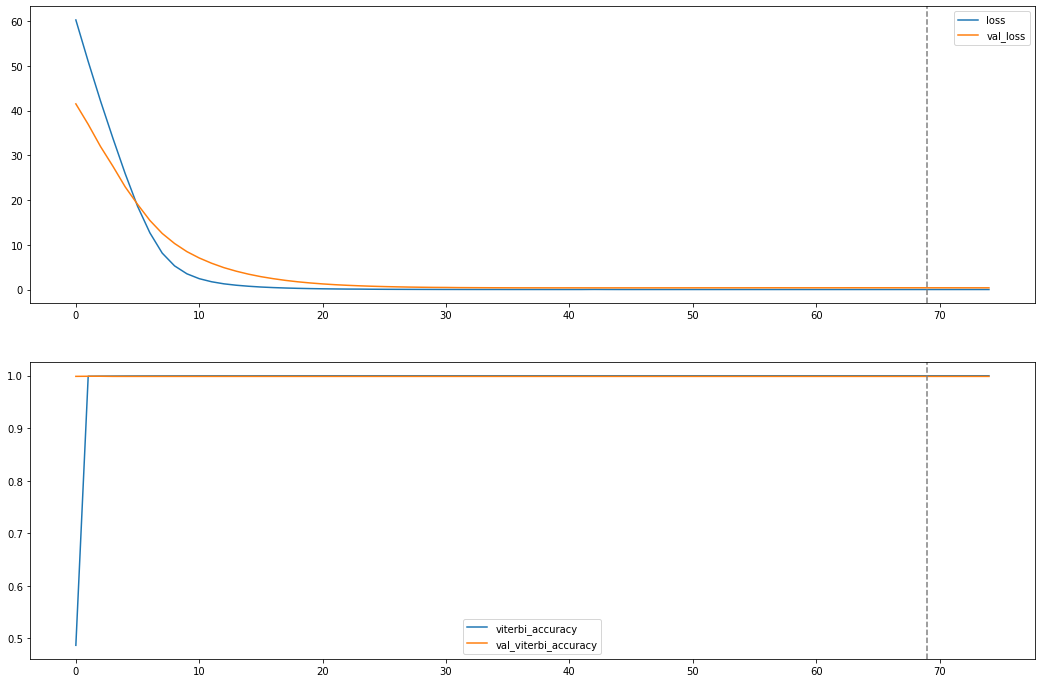

In [13]:
history = pd.read_csv(results_dir + 'history.csv')
best_idx = np.load(results_dir + 'best_idx.npy')

fig, axes = plt.subplots(2, 1, figsize=(18,12))
display(history)
history[["loss", "val_loss"]].plot(ax=axes[0]).axvline(x=best_idx, color='gray', linestyle='--')
history[["viterbi_accuracy", "val_viterbi_accuracy"]].plot(ax=axes[1]).axvline(x=best_idx, color='gray', linestyle='--')
plt.show()

## Mostrar metricas

,Unnamed: 0,pr_auc_macro,pr_auc_micro,f1_micro,f1_macro,f1_samples,precision_micro,precision_macro,precision_samples,recall_micro,recall_macro,recall_samples
0,0,0.085452,0.989475,0.994527,0.101069,0.994527,0.994527,0.193768,0.994527,0.994527,0.090139,0.994527
1,1,0.164805,0.991545,0.995606,0.228533,0.995606,0.995606,0.356038,0.995606,0.995606,0.186773,0.995606
2,2,0.240745,0.993240,0.996489,0.321690,0.996489,0.996489,0.492284,0.996489,0.996489,0.277733,0.996489
3,3,0.321376,0.994510,0.997149,0.410526,0.997149,0.997149,0.610824,0.997149,0.997149,0.354230,0.997149
4,4,0.377450,0.995000,0.997404,0.469055,0.997404,0.997404,0.650066,0.997404,0.997404,0.412117,0.997404
...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,0.700185,0.998437,0.999189,0.768101,0.999189,0.999189,0.820078,0.999189,0.999189,0.732109,0.999189
71,71,0.686871,0.998223,0.999078,0.759171,0.999078,0.999078,0.798583,0.999078,0.999078,0.738440,0.999078
72,72,0.691761,0.998412,0.999176,0.762941,0.999176,0.999176,0.816575,0.999176,0.999176,0.725715,0.999176
73,73,0.692443,0.998311,0.999124,0.762411,0.999124,0.999124,0.816189,0.999124,0.999124,0.726180,0.999124


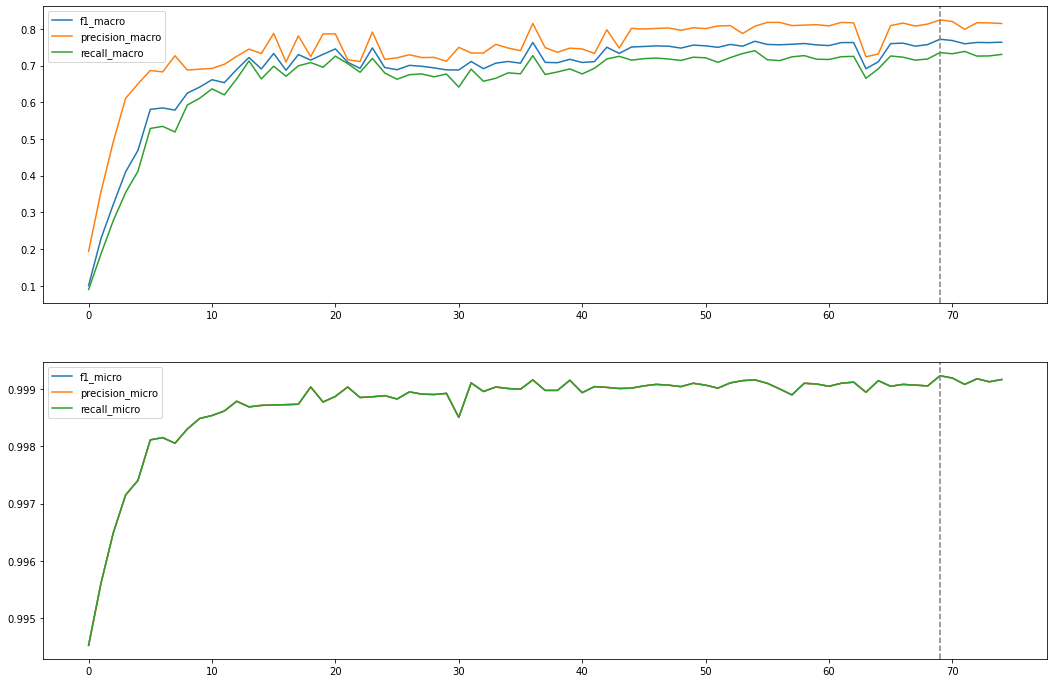

In [14]:
metricas = pd.read_csv(results_dir + 'metricas.csv')

fig, axes = plt.subplots(2, 1, figsize=(18,12))
display(metricas)
metricas[["f1_macro", "precision_macro", "recall_macro"]].plot(ax=axes[0]).axvline(x=best_idx, color="gray", linestyle="--")
metricas[["f1_micro", "precision_micro", "recall_micro"]].plot(ax=axes[1]).axvline(x=best_idx, color="gray", linestyle="--")

## Mostrar best_prediction

<AxesSubplot:>

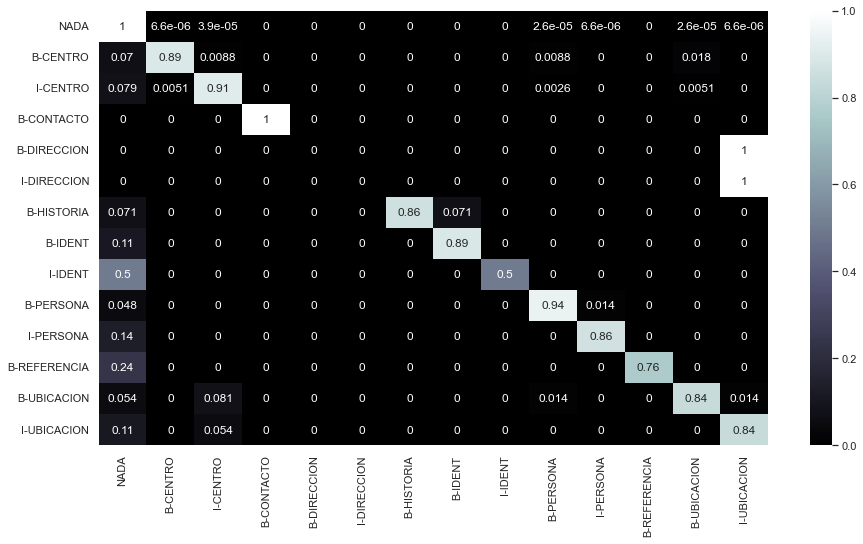

In [15]:
prediction = np.load(results_dir + 'best_prediction.npy')
best_prediction_true = np.zeros(shape=[prediction.shape[0]])
best_prediction_pred = np.zeros(shape=[prediction.shape[0]])

for i in range(prediction.shape[0]):
    best_prediction_pred[i,] = np.argmax(prediction[i,0,])
    best_prediction_true[i,] = np.argmax(prediction[i,1,])
    
sbn.set(rc = {'figure.figsize':(15,8)})

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

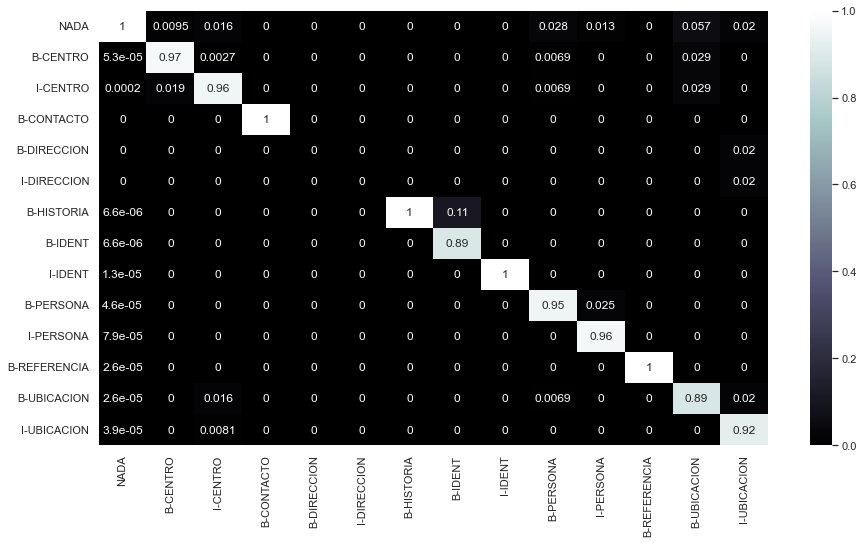

In [16]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

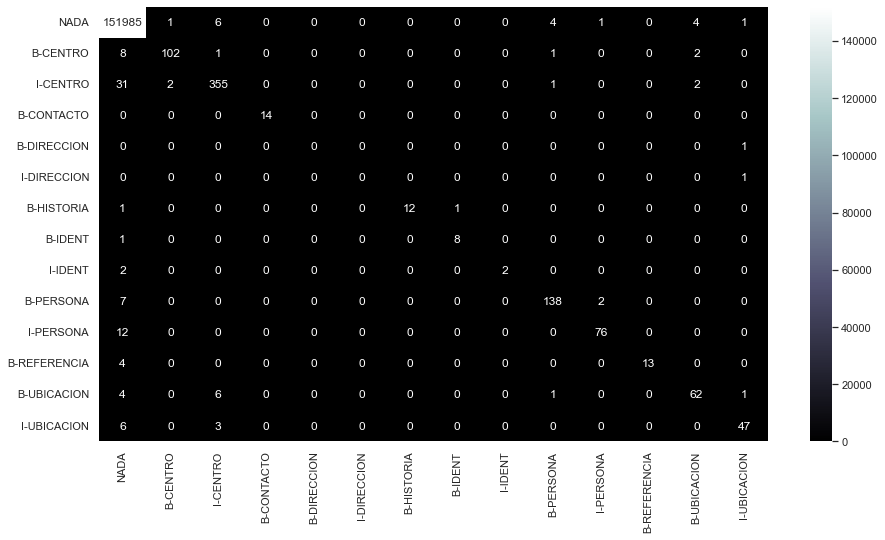

In [17]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar validación

In [18]:
# Ocultar warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

print(metrics.classification_report(best_prediction_true, best_prediction_pred, target_names=LABELS))

              precision    recall  f1-score   support

        NADA       1.00      1.00      1.00    152002
    B-CENTRO       0.97      0.89      0.93       114
    I-CENTRO       0.96      0.91      0.93       391
  B-CONTACTO       1.00      1.00      1.00        14
 B-DIRECCION       0.00      0.00      0.00         1
 I-DIRECCION       0.00      0.00      0.00         1
  B-HISTORIA       1.00      0.86      0.92        14
     B-IDENT       0.89      0.89      0.89         9
     I-IDENT       1.00      0.50      0.67         4
   B-PERSONA       0.95      0.94      0.95       147
   I-PERSONA       0.96      0.86      0.91        88
B-REFERENCIA       1.00      0.76      0.87        17
 B-UBICACION       0.89      0.84      0.86        74
 I-UBICACION       0.92      0.84      0.88        56

    accuracy                           1.00    152932
   macro avg       0.82      0.74      0.77    152932
weighted avg       1.00      1.00      1.00    152932



## Cargar modelo

In [19]:
# Crear una nueva instancia del modelo
crf = _crf.CRF(classes)
model = tensorflow.keras.models.load_model(str(results_dir + 'modelo_mejor.h5'),
                                          custom_objects = {'crf_loss': crf.loss,
                                                            'viterbi_accuracy': crf.accuracy})

# Re-evaluar el modelo para todo el conjunto de test
values, prediction = evaluar_red(model, gen_test, null_class, threshold) 
test_prediction = prediction
np.save(str(results_dir + 'test_prediction.npy'), test_prediction)

## Mostrar test_prediction

<AxesSubplot:>

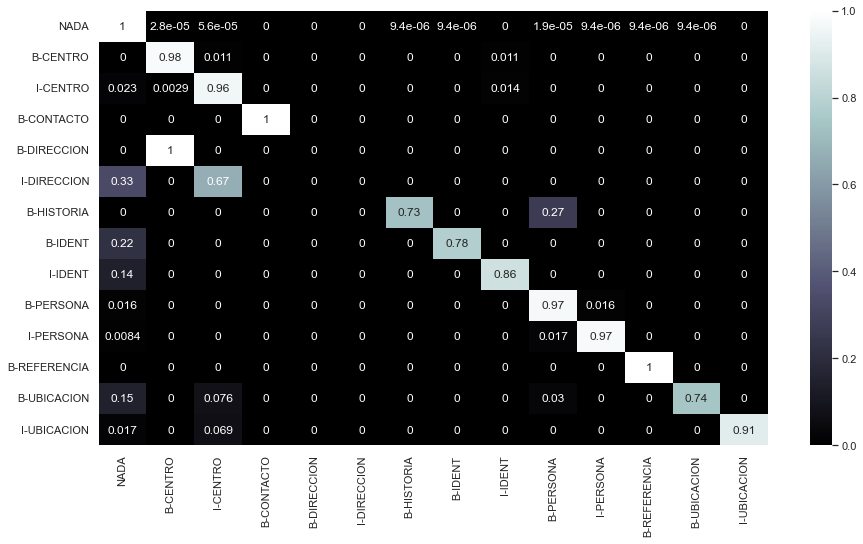

In [20]:
test_prediction = np.load(results_dir + 'test_prediction.npy')
test_prediction_true = np.zeros(shape=[test_prediction.shape[0]])
test_prediction_pred = np.zeros(shape=[test_prediction.shape[0]])

for i in range(test_prediction.shape[0]):
    test_prediction_pred[i,] = np.argmax(test_prediction[i,0,])
    test_prediction_true[i,] = np.argmax(test_prediction[i,1,])

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

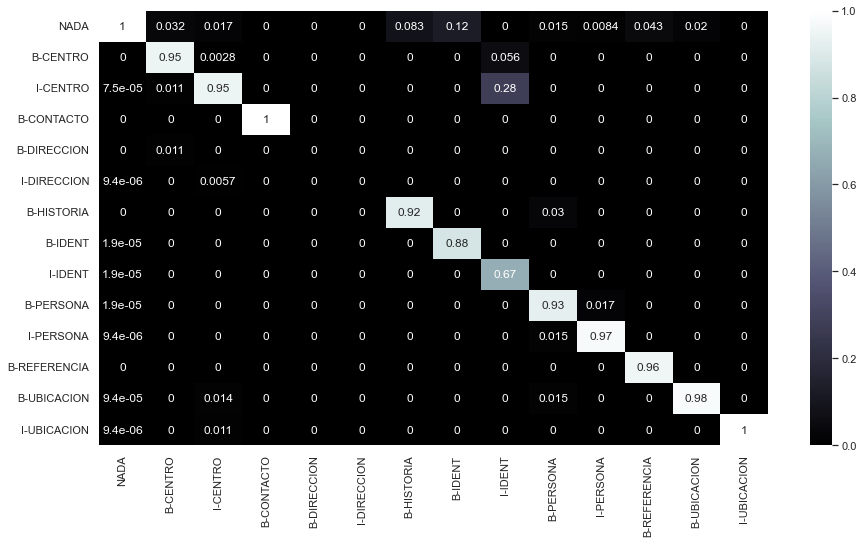

In [21]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

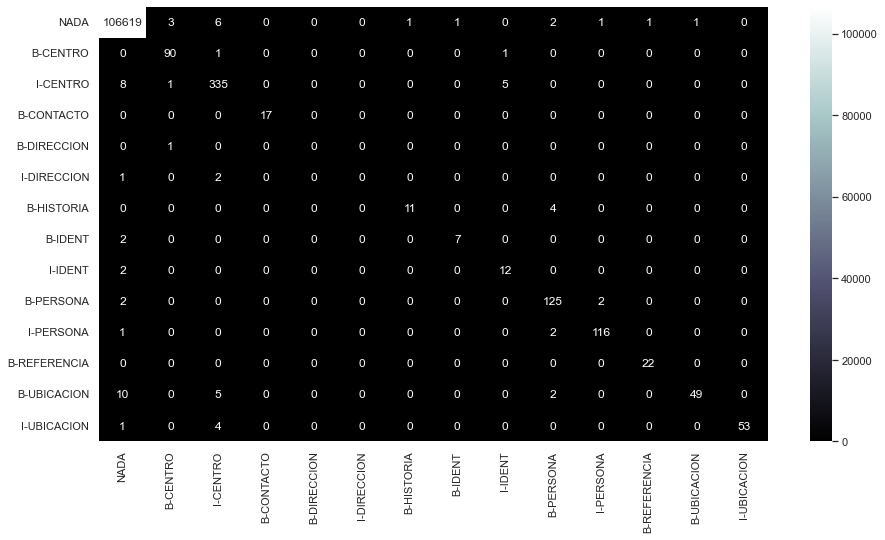

In [22]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar test 

In [23]:
print(metrics.classification_report(test_prediction_true, test_prediction_pred, target_names=LABELS))

              precision    recall  f1-score   support

        NADA       1.00      1.00      1.00    106635
    B-CENTRO       0.95      0.98      0.96        92
    I-CENTRO       0.95      0.96      0.95       349
  B-CONTACTO       1.00      1.00      1.00        17
 B-DIRECCION       0.00      0.00      0.00         1
 I-DIRECCION       0.00      0.00      0.00         3
  B-HISTORIA       0.92      0.73      0.81        15
     B-IDENT       0.88      0.78      0.82         9
     I-IDENT       0.67      0.86      0.75        14
   B-PERSONA       0.93      0.97      0.95       129
   I-PERSONA       0.97      0.97      0.97       119
B-REFERENCIA       0.96      1.00      0.98        22
 B-UBICACION       0.98      0.74      0.84        66
 I-UBICACION       1.00      0.91      0.95        58

    accuracy                           1.00    107529
   macro avg       0.80      0.78      0.79    107529
weighted avg       1.00      1.00      1.00    107529

